# Run general analysis on phagophore membranes

In [26]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
from pyvistaqt import BackgroundPlotter

# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)
    
from utility_functions import (load_segmentation_tif, 
                               namedtuple_to_dict, 
                               dicts_all_equal, 
                               clean_pointlist_clustering)
from distance_functions import minimum_distance_refined
from fitting_functions import (ls_sphere_3, 
                               ellipsoid_fit_rmse, 
                               sphericity_of_ellipsoid, 
                               sphericity_index_ellipsoid, 
                               generate_ellipsoid_even, 
                               generate_sphere_even)
from fit_ellipsoid_weiss import fit_ellipsoid_iter, check_convergence_ellipsoid_fit
from opening_angle_functions import phagophore_opening_angle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input

In [27]:
fname_in = Path('../example_data/phagophore_analysis/Phagophore_middle_labels.tif')
pix_size = 1.408

# Segmentation labels
seg_labels = {'inner': 1,
              'outer': 2,
              'rim': 3}

# Parameters 
n_iter_ellipsoid_fit = 10000 # Check plot if fit converged!
n_iter_ell_run2 = 50000 # If first fit didn't converge, try once more with this number of iterations
ellipsoid_fit_samplesize = 2000

clean_points_clustering = False # Whether to find outlier points with clustering

# Results dictionary for comparison
fname_compare = fname_in.parent / 'Phagophore_results.npy'

In [28]:
# For visualization
window_size_0 = [512,512]
cpos = {'points': [(613.2361218667041, -345.6736538983374, 804.1761468432726),
                   (318.0, 625.0, 103.0),
                   (-0.18533229149002745, 0.5377558197272821, 0.8224783401892688)],
       'fits': [(134.05519106408673, 728.3388319306499, -1326.1850713469473),
                  (318.0849037026922, 633.5867890633508, 211.84321658237687),
                  (0.8856876772441696, 0.4577205594903096, -0.07777678186776335)]}

## Load and process segmentation data

In [29]:
points = load_segmentation_tif(fname_in.as_posix(), seg_labels, verbose=True)

Input volume shape is (928, 928, 202)


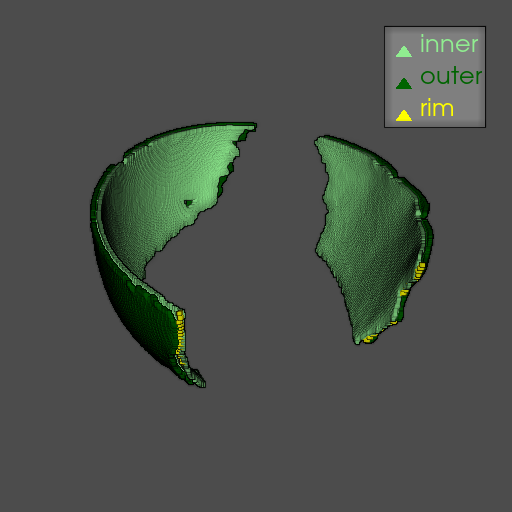

In [30]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()
colors = ['lightgreen', 'darkgreen', 'yellow']
for i, (key, p) in enumerate(points.items()):
    p0.add_mesh(p, color = colors[i], label=key)
p0.add_legend()
p0.camera_position = cpos['points']
_ = p0.show()

## Calculate intermembrane distances

In [31]:
# Gives refined and unrefined output in named tuple
dist_res = minimum_distance_refined(points['inner'], points['outer'])
dist_nm = dist_res.dist_refined*pix_size
points['inner_ref'] = dist_res.a_refined
points['outer_ref'] = dist_res.b_refined


# Calculate mean and std
dist_mean_nm = np.mean(dist_nm)
dist_std_nm = np.std(dist_nm)

# Save results in dictionary
d_dist = {'dist_values': dist_nm, 'dist_mean_nm': dist_mean_nm, 'dist_std_nm': dist_std_nm}
print("Mean refined distance {:.2f} nm, std {:.2f} nm".format(dist_mean_nm, dist_std_nm))

# Suffix for refined points
ref_suffix = '_ref'

Mean refined distance 9.93 nm, std 0.89 nm


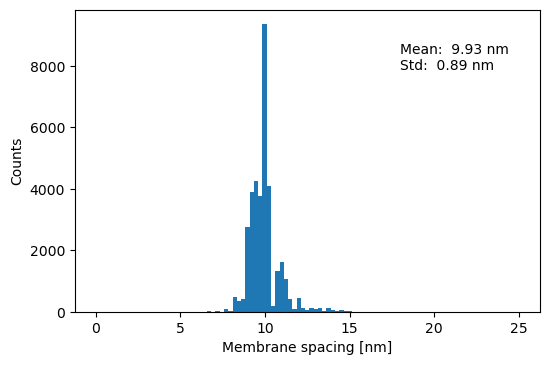

In [32]:
fig, ax = plt.subplots(dpi=100)
bins = np.linspace(0,25,100)

ax.hist(dist_nm, bins)
ax.text(18,0.8*ax.get_ylim()[1], "Mean: {:5.2f} nm \nStd: {:5.2f} nm".format(dist_mean_nm, dist_std_nm))

ax.set_xlabel('Membrane spacing [nm]')
ax.set_ylabel('Counts')
plt.show()

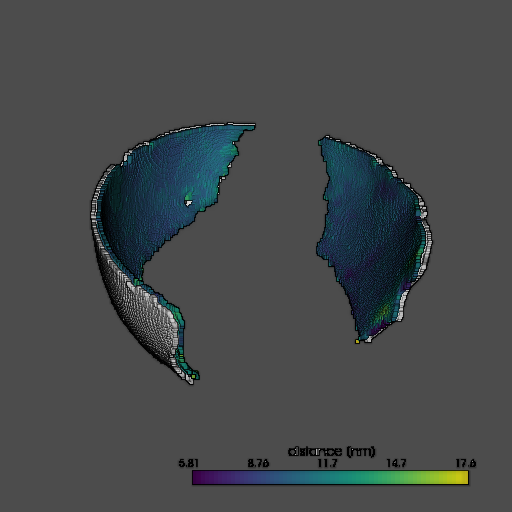

In [33]:
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()

p0.add_mesh(points['inner_ref'], scalars=dist_nm)
p0.add_scalar_bar(title='distance [nm]')
p0.add_mesh(points['outer_ref'], color='white')


p0.camera_position = cpos['points']
_ = p0.show()

### Optional: clean with clustering

In the example phagophore, no outlier points are found with the given settings, so we skip this step.

In [34]:
# Additional cleaning step using clustering

if clean_points_clustering:
    out_ids = clean_pointlist_clustering([points['inner_ref'], points['outer_ref']])

    print('Found {} outliers in {} point pairs.'.format(len(out_ids), len(points['inner_ref'])))

    # Clean distances
    dist_nm_clean = np.delete(dist_nm, out_ids)
    dist_clean_mean_nm = np.mean(dist_nm_clean)
    dist_clean_std_nm = np.std(dist_nm_clean)
    print("Before: mean refined distance {:.2f} nm, std {:.2f} nm.".format(dist_mean_nm, dist_std_nm))
    print("After cleaning: mean refined distance {:.2f} nm, std {:.2f} nm".format(dist_clean_mean_nm, 
                                                                                  dist_clean_std_nm))
    # Clean points
    for key in ['inner_ref', 'outer_ref']:
        key_clean = key+'_clean'
        points[key_clean] = np.delete(points[key], out_ids, axis=0)
        
    # Update results
    d_dist.update({'dist_values_clean': dist_nm_clean, 
                   'dist_mean_nm_clean': dist_clean_mean_nm, 
                   'dist_std_nm_clean': dist_clean_std_nm})
    
    # Update suffix for refined points
    ref_suffix = '_ref_clean'

## Sphere and ellipsoid fits

Fitting of refined inner points.
Sphere fit: inner membrane radius is 288.51474778892566 nm
Sphere fit error is 12.704770480134522 nm
Ellipsoid fitting


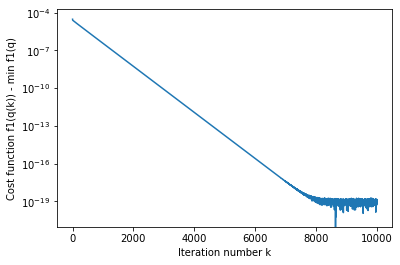

  0%|          | 24/35496 [00:00<02:29, 237.28it/s]

Calculating ellipsoid fit rmse...


100%|██████████| 35496/35496 [02:33<00:00, 231.00it/s]


Ellipsoid fit rmse is 2.611471252005741 nm.
Sphericity index of best-fitting ellipsoid is 0.8555586676789022 for inner membrane.
Sphericity of best-fitting ellipsoid is 0.9884671369765076 for inner membrane.
Fitting of refined outer points.
Sphere fit: outer membrane radius is 298.2648093709338 nm
Sphere fit error is 12.812709307541452 nm
Ellipsoid fitting


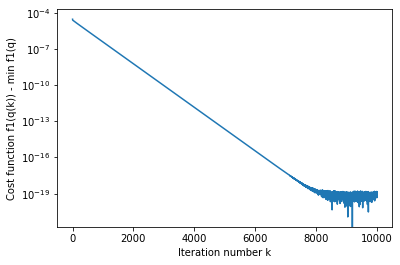

  0%|          | 23/35496 [00:00<02:37, 225.35it/s]

Calculating ellipsoid fit rmse...


100%|██████████| 35496/35496 [02:29<00:00, 237.16it/s]

Ellipsoid fit rmse is 2.7114331739048607 nm.
Sphericity index of best-fitting ellipsoid is 0.8583540719767612 for outer membrane.
Sphericity of best-fitting ellipsoid is 0.989009355280422 for outer membrane.


In [35]:
#Sphere and ellipsoid fitting of inner and outer points

# Dictionary for results
d_fit = {}
# Loop over inner and outer points
for label in ["inner", "outer"]:
    print(f'Fitting of refined {label} points.')
    p_tmp = points[label+ref_suffix]
    dt = {} # temporary dict
    
    # Sphere fit
    dt["sphere_center"], dt["sphere_radius"], dt["sphere_rmse"] = ls_sphere_3(p_tmp) # least squares fit
    dt["sphere_radius_nm"] = dt["sphere_radius"]*pix_size
    print("Sphere fit: {} membrane radius is {} nm".format(label, dt["sphere_radius_nm"]))
    print("Sphere fit error is {} nm".format(dt["sphere_rmse"]*pix_size))
    
    # Ellipsoid fit
    # subsample to make things faster 
    n_points = p_tmp.shape[0]
    if n_points > ellipsoid_fit_samplesize:
        points_sorted = p_tmp[ np.argsort(p_tmp[:,2]), : ] # sort points by z value
        sample_step = int(n_points // ellipsoid_fit_samplesize)
    
        points_sample = p_tmp[0::sample_step].copy() # try homogeneous subsampling with respect to z
    else:
        points_sample = p_tmp
    
    print('Ellipsoid fitting')
    ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ellipsoid_fit, 
                                 plot_CF=True, return_CF=True)
    dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res
    # Check convergence of ellipsoid fit, re-run if necessary
    if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
        dt["ellipsoid_fit_converged"] = True
        dt["ellipsoid_fit_n_iter"] = n_iter_ellipsoid_fit
    else :
        print('Ellipsoid fit did not converge in first run, re-try with {} iterations.'.format(n_iter_ell_run2))
        ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ell_run2, plot_CF=True, return_CF=True)
        dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res
        
        if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
            dt["ellipsoid_fit_converged"] = True
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2
        else:
            print("Ellipsoid still not converged in run 2.")
            dt["ellipsoid_fit_converged"] = False
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2
    
    if dt["ellipsoid_fit_converged"]:
        # If ellipsoid fit converged, also calculate rmse and other parameters  
        print('Calculating ellipsoid fit rmse...')
        dt["ellipsoid_rmse"] = ellipsoid_fit_rmse(p_tmp, dt["ellipsoid_axes"], dt["ellipsoid_center"], 
                                                  dt["ellipsoid_rotmat"], return_full=False)    
        print('Ellipsoid fit rmse is {} nm.'.format(dt["ellipsoid_rmse"]*pix_size))
        dt["ellipsoid_axes_nm"] = dt["ellipsoid_axes"]*pix_size
        
        # Sphericity (two measures, sphericity index and "classical" sphericity)                
        dt["sphericity_index"] = sphericity_index_ellipsoid(dt["ellipsoid_axes"])
        print("Sphericity index of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_index"], label))
        
        dt["sphericity_classical"] = sphericity_of_ellipsoid(dt["ellipsoid_axes"], verbose=False)
        print("Sphericity of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_classical"], label))

    # Save results into dictionary
    d_fit[label] = dt


In [36]:
# Plot

surf_ell = generate_ellipsoid_even(d_fit['inner']['ellipsoid_axes'], 
                                   d_fit['inner']['ellipsoid_center'], 
                                   d_fit['inner']['ellipsoid_rotmat'], 
                                   n_points=1000, 
                                   return_mesh=True, return_angles=False)

surf_sphere = generate_sphere_even(d_fit['inner']['sphere_radius'], 
                                   d_fit['inner']['sphere_center'], 
                                   n_points=1000, 
                                   return_mesh=True)

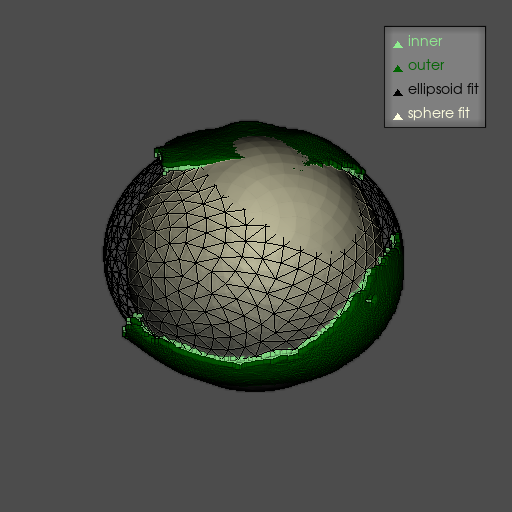

In [37]:
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()

p0.add_mesh(points['inner'+ref_suffix], color='lightgreen', label='inner')
p0.add_mesh(points['outer'+ref_suffix], color='darkgreen', label='outer')
p0.add_mesh(surf_ell, style='wireframe', color='black', label='ellipsoid fit')
p0.add_mesh(surf_sphere, color='lightyellow', label='sphere fit')
p0.add_legend()

p0.camera_position = cpos['fits']
_ = p0.show()

## Estimate completeness via rim opening angle

In [38]:
d_roa, d_all_angles = phagophore_opening_angle(points['rim'], points['inner'+ref_suffix], dist_cutoff=50, angle_bin_number=36,
                                                 cone_refinement=True, cone_ref_min_angular_range=90)

print('The rim opening angle is {:.1f} ± {:.1f} degrees.'.format(d_roa['roa_mean'], d_roa['roa_std']))

The rim opening angle is 118.1 ± 2.5 degrees.


## Save results or compare to previously saved results

In [39]:
# Make one dictionary and turn all named tuples into dictionaries for saving
res_dict = {'dist': d_dist,
            'fit': d_fit,
            'opening_angle': d_roa}
res_dict_all = namedtuple_to_dict(res_dict)
overwrite_res_dict = False

# Save dictionaries with np.save as npy files
if overwrite_res_dict:
    np.save(fname_compare, res_dict_all)

In [40]:
# Load and compare

# Load reference
res_dict_ref = np.load(fname_compare, allow_pickle=True).item()

if dicts_all_equal(res_dict_ref, res_dict_all):
    print('Results are identical to previously saved ones.')
else:
    print('Check: results are not identical with previously saved ones.')

Results are identical to previously saved ones.
